In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [244]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Exploratory Data Analysis

## Reading dataset

__Observation__:
- From looking at the dataset documentation we observe that many of the categorical features contain a value which can be 'NA' or 'None' string. By default `pd.read_csv` would interpret this as a missing values which is not the case.

__Solution__:
- Change the list of strings to be intepreted as missing values

In [245]:
file ='house-prices.csv'
df = pd.read_csv(file, na_values = [''],keep_default_na=False)
df.drop(['Order', 'PID'], axis=1, inplace=True)

In [246]:
df.isna().sum().sum()

11670

In [247]:
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,20,RL,75.00,10170,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,160,RM,21.00,2001,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,20,RL,70.00,10552,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,190,RM,60.00,10120,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


In [248]:
df.shape

(2430, 80)

__Observation__:
- There are 80 features and 2430 entries
- We observe there's a mix of categorical and numerical features

Data types of the different columns in the dataset:

In [249]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [250]:
continuous_columns = df.dtypes[df.dtypes == 'float64'].index
continuous_columns

Index(['Lot Frontage', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area'],
      dtype='object')

In [251]:
discrete_columns = df.dtypes[df.dtypes == 'int64'].index
discrete_columns

Index(['MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice'],
      dtype='object')

In [252]:
categorical_columns = df.dtypes[df.dtypes == 'object'].index
categorical_columns

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'Sale Condition'],
      dtype='object')

__Observation__:
- Comparing the data types with the documentation about the dataset we observe the following mismatches:
- Variables that should be categorical: __'MS SubClass'__;
- Variables that should be continuous : __'Lot Area', '1st Flr SF', '2nd Flr SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch','3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val'and 'SalePrice'__;
- Variables that should be discrete   : __'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars'__;
- Observing the values of the variables that should be discrete we see that see take only integer values as expected;
  
__Solution__:
- We convert the datatypes of all the above variables to the correct ones;
- For the discrete variables (`int64`) we first convert all the variables to `Int64`, since only this integer datatype supports `NA` values;

In [253]:
# Convert to Categorical
df['MS SubClass'] = df['MS SubClass'].astype(str)

# Convert to Discrete (but first convert all int64 to Int64 )
for col in discrete_columns:
        df[col] = df[col].astype('Int64')

# Convert to Continuous
convert_to_continuous = ['Lot Area', '1st Flr SF', '2nd Flr SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch','3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice']
for col in convert_to_continuous:
        df[col] = df[col].astype('float64')


convert_to_discrete = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars']
for col in convert_to_discrete:
        df[col] = df[col].astype('Int64')


We obtain again the list of datatypes after the conversions:

In [254]:
continuous_columns = df.dtypes[df.dtypes == 'float64'].index
discrete_columns = df.dtypes[df.dtypes == 'Int64'].index
categorical_columns = df.dtypes[df.dtypes == 'object'].index

Next we'll perform the data cleaning operations (Incorrect and missing values, inconsistencies, and outliers) for each datatype separately.

## Categorical Features

In [255]:
print(f'Number of categorical features: {len(categorical_columns)}')

Number of categorical features: 43


### Missing values:

In [256]:
print(f'Total missing values: {df[categorical_columns].isna().sum().sum()}')

Total missing values: 11082


In [257]:
df_categorical_missing = df[categorical_columns].isna().sum().to_frame(name='total')
df_categorical_missing = df_categorical_missing[df_categorical_missing['total']!=0].sort_values('total', ascending=False)
df_categorical_missing['percentage'] = df_categorical_missing['total']/len(df)*100
df_categorical_missing

,total,percentage
Pool QC,2418,99.51
Misc Feature,2340,96.30
Alley,2267,93.29
Fence,1941,79.88
Fireplace Qu,1186,48.81
Garage Finish,138,5.68
Garage Qual,138,5.68
Garage Cond,138,5.68
Garage Type,136,5.60
Bsmt Exposure,74,3.05


__Observation__:
- Except for 'Electrical' all other features have a value which corresponds to 'None' according to the dataset doc 
- From a quick check of the original CSV file, it is highly probable that these missing values should instead be 'None', corresponding to cases where such a feature is not present

__Solution__:
- Replace the missing value for 'Electrical' with the mode
- Replace the missing values of remaining features with 'None'

In [258]:
# Replace missing values with the mode
mode_value = df['Electrical'].mode()[0]
df['Electrical'].fillna(mode_value, inplace=True)

In [259]:
# Replace missing values with 'None'
df[categorical_columns] = df[categorical_columns].fillna('None')

In [260]:
print("Missing values in categorical columns after cleaning: ", df[categorical_columns].isna().sum().sum())

Missing values in categorical columns after cleaning:  0


## Numerical discrete columns

In [261]:
print('Number of numerical discrete features:', len(discrete_columns))

Number of numerical discrete features: 17


### Missing Values:

In [262]:
print(f'Total missing values: {df[discrete_columns].isna().sum().sum()}')

Total missing values: 143


In [263]:
df_discrete_missing = df[discrete_columns].isna().sum().to_frame(name='total')
df_discrete_missing = df_discrete_missing[df_discrete_missing['total']!=0].sort_values('total', ascending=False)
df_discrete_missing['percentage'] = df_discrete_missing['total']/len(df)*100
df_discrete_missing

,total,percentage
Garage Yr Blt,138,5.68
Bsmt Full Bath,2,0.08
Bsmt Half Bath,2,0.08
Garage Cars,1,0.04


__Observation__:
- 'Garage Yr Blt' is the feature with more missing values, these correspond to entries where there is no garage.
- For 'Bsmt Full Bath', 'Bsmt Half Bath' and 'Garage Cars' the number of missing values is very small

__Solution__: 
- For 'Garage Yr Blt': 
    - check if the missing values correpond mostly to propreties where a garage is not present;
    - if yes, it's not obvious which value to give to 'Garage Yr Blt' these cases...
    - check correlation between 'Year Blt' and 'Garage Yr Blt'
    - if correlation is high we decide to drop the 'Garage Yr Blt feature'
- For 'Bsmt Full Bath', 'Bsmt Half Bath' and 'Garage Cars', fill missing values with the mode.
    - If any inconsistencies arise, they will be dealt with later on

In [264]:
# Replace missing values with the mode
features = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars']

for feature in features:
    mode_value = df[feature].mode()[0]
    df[feature].fillna(mode_value, inplace=True)

In [265]:
df[df['Garage Yr Blt'].isna()]['Garage Type'].value_counts()

Garage Type
None      136
Detchd      2
Name: count, dtype: int64

In [266]:
df['Garage Yr Blt'].corr(df['Year Built'])

0.835510232679516

As explained before, we decide to drop the feature 'Garage Yr Blt'

In [267]:
df.drop('Garage Yr Blt', axis=1, inplace=True)
discrete_columns = df.dtypes[df.dtypes == 'Int64'].index

In [268]:
print(f"Missing values in discrete columns after cleaning: {df[discrete_columns].isna().sum().sum()}")

Missing values in discrete columns after cleaning: 0


## Numerical continuous variable

In [269]:
print('Number of numerical continuous features:', len(continuous_columns))

Number of numerical continuous features: 20


### Missing Values:

In [270]:
print(f"Missing values in continuous columns: {df[continuous_columns].isna().sum().sum()}")

Missing values in continuous columns: 445


In [271]:
df_continuous_missing = df[continuous_columns].isna().sum().to_frame(name='total')
df_continuous_missing = df_continuous_missing[df_continuous_missing['total']!=0].sort_values('total', ascending=False)
df_continuous_missing['percentage'] = df_continuous_missing['total']/len(df)*100
df_continuous_missing

,total,percentage
Lot Frontage,420,17.28
Mas Vnr Area,20,0.82
BsmtFin SF 1,1,0.04
BsmtFin SF 2,1,0.04
Bsmt Unf SF,1,0.04
Total Bsmt SF,1,0.04
Garage Area,1,0.04


__Observation__:
- Feature 'Lot Frontage' has a significant ammount of missing values, these could be from properties with no street connection, but this should be verified
- 'Mas Vnr Area' (Masonry veneer area in square feet) with missing values could also be coming from properties with no Masonry veneer surface

__Solution__:
- Observe relation between 'Lot Frontage' and 'Lot Config' for properties with no lot frontage.
- Check if missing values in 'Mas Vnr Area', also have 'Mas Vnr Type' equal to 'NA'
- If previous 

Missing values in 'Lot Frontage':

In [272]:
df[df['Lot Frontage'].isna()]['Lot Config'].value_counts()

Lot Config
Inside     235
Corner      86
CulDSac     79
FR2         17
FR3          3
Name: count, dtype: int64

Most missing values in 'Lot Frontage' correspond to lot configurations where it's more likely that there's no connection to street. Hence it seemes reasonable that these missing values should correpond to 0 feet of street connection of the property.

In [273]:
df['Lot Frontage'].fillna(0, inplace=True)

Missing values in 'Mas Vnr Area':

In [274]:
df[df['Mas Vnr Area'].isna()]['Mas Vnr Type'].value_counts()

Mas Vnr Type
None    20
Name: count, dtype: int64

All missing values in 'Mas Vnr Area' correspond to entries where 'Mas Vnr Type' is 'NA', hence it makes sense that these values should actually be zero.

In [275]:
df['Mas Vnr Area'].fillna(0, inplace=True)

Next we look at the other missing values in some Basement related features. Below we see that the 3 missing values correspond to a single entry, and we decide to drop this entry.

In [276]:
df[df['BsmtFin SF 1'].isna() | df['BsmtFin SF 2'].isna() | df['Bsmt Unf SF'].isna()]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
104,20,RM,99.00,5940.00,Pave,None,IR1,Lvl,AllPub,FR3,...,0.00,None,MnPrv,None,0.00,4,2008,ConLD,Abnorml,79000.00


In [277]:
df.drop([104], inplace=True)

After the previous cleanup, the following reduced number of features with missing values remain:

In [278]:
df_missing = df.isna().sum().to_frame(name='total')
df_missing = df_missing[df_missing['total']!=0].sort_values('total', ascending=False)
df_missing['percentage'] = df_missing['total']/len(df)*100
df_missing.head()

,total,percentage
Garage Area,1,0.04


In [279]:
print(f"Missing values in continuous columns after cleaning: {df[continuous_columns].isna().sum().sum()}")

Missing values in continuous columns after cleaning: 1


# Inconsistencies

Next we'll analyse possible incosistencies among the following related variables:

- Basement variables
- Garage Year Built
- Finished vs living areas
- 'Year Built' vs 'Year Remod/Add'

### Basement variables

Next we check for possible inconsistencies in Basement related features with missing values

In [280]:
basement_columns = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']

We start by looking at entries where at least one feature indicates 'NA', but where this is inconsistent witht he other features.

In [281]:
q1 = '(`Bsmt Qual` == "NA") | (`Bsmt Exposure` == "NA") | (`BsmtFin Type 1` == "NA") | (`BsmtFin Type 2` == "NA")'
q2 = '~((`Bsmt Qual` == "NA") & (`Bsmt Exposure` == "NA") & (`BsmtFin Type 1` == "NA") & (`BsmtFin Type 2` == "NA") & (`BsmtFin SF 1` == 0.00) & (`BsmtFin SF 2` == 0.00) & (`Bsmt Unf SF` == 0.00) & (`Total Bsmt SF` == 0.00) & (`Bsmt Full Bath` == 0) & (`Bsmt Half Bath` == 0))'
df.query(q1).query(q2)[basement_columns]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath


__Observation__:
- The previous entries show some kind of inconsistency, among the variables describing the basement facilities

__Solution__:
- Since these are only a few entries, we'll fix the entries using common sense
- We'll populate the column `'Bsmt Exposure'` of entries 875, 1681 and 1726, where  indicates there is no basement but we there's a basement in Unfinished conditions, with `'Bsmt Exposure'=='No'` that indicates no exposure to outside

In [282]:
df.loc[104, ['BsmtFin SF 1','BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']] = 0
df.loc[602, ['BsmtFin Type 2']] = 'Unf'
df.loc[[875,1681, 1726], ['Bsmt Exposure']] = 'No'

Next we check for potential inconsistencies among the various surface features.

In [283]:
inconsistent_basement_surface = (df['BsmtFin SF 1'] + df['BsmtFin SF 2'] + df['Bsmt Unf SF']) != df['Total Bsmt SF']
inconsistent_basement_surface.sum()

0

__Observation__:
- The Basement surface features are consistent among for all entries

### Garage Variables

In [284]:
garage_columns = ['Garage Type', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond']

Again, we start by looking at entries where at least one feature indicates 'NA', but where this is inconsistent witht he other features.

In [285]:
q1 = '(`Garage Type` == "NA") | (`Garage Finish` == "NA") | (`Garage Cars` == 0) | (`Garage Area` == 0) | (`Garage Qual` == "NA") & (`Garage Cond` == "NA")'
q2 = '~((`Garage Type` == "NA") & (`Garage Finish` == "NA") & (`Garage Cars` == 0) & (`Garage Area` == 0) & (`Garage Qual` == "NA") & (`Garage Cond` == "NA"))'
df.query(q1).query(q2)[garage_columns]

,Garage Type,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
16,None,None,0,0.00,None,None
48,None,None,0,0.00,None,None
62,None,None,0,0.00,None,None
73,None,None,0,0.00,None,None
76,None,None,0,0.00,None,None
77,None,None,0,0.00,None,None
106,None,None,0,0.00,None,None
117,None,None,0,0.00,None,None
120,None,None,0,0.00,None,None
134,None,None,0,0.00,None,None


__Observation__:
- There are two entries with inconsistent values

__Solution__:
- We decide to drop these since they are just two

In [286]:
df.drop([1114, 1565], inplace=True)

## Year Built vs Year Remod/Add vs Year Sold 

We verify that the following conditions are verified:
-  'Yr Sold' >= 'Year Remod/Add'
- 'Year Remod/Add' >= 'Year Built' 

In [287]:
q = '(`Year Built` > `Year Remod/Add`)'
df.query(q)

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice


In [288]:
q = '(`Year Built` > `Yr Sold`)'
df.query(q)[['Year Built', 'Year Remod/Add', 'Yr Sold']]

,Year Built,Year Remod/Add,Yr Sold
71,2008,2009,2007


__Observation__:  
- No inconsistencies observed between 'Year Built' and 'Year Remod/Add'
- For entrie 71 the 'Yr Sold' should be at least 2009

__Solution__:  
- Manually change this value

In [289]:
# Change value of Yr SOld for entry 71 to 2009
df.loc[71,'Yr Sold'] = 2009

## Misc Feature and Misc Val

When there is no 'Misc Feature' the corresponding 'Misc Val' should be 0 

In [290]:
q = '(`Misc Feature` ==  "NA") & (`Misc Val` != 0)'
df.query(q)[['Misc Feature', 'Misc Val']]

,Misc Feature,Misc Val


__Observations__:  
- No inconsistencies observed

# Feature distribution:

We next observe the distribution of all the features

## Categorical Features

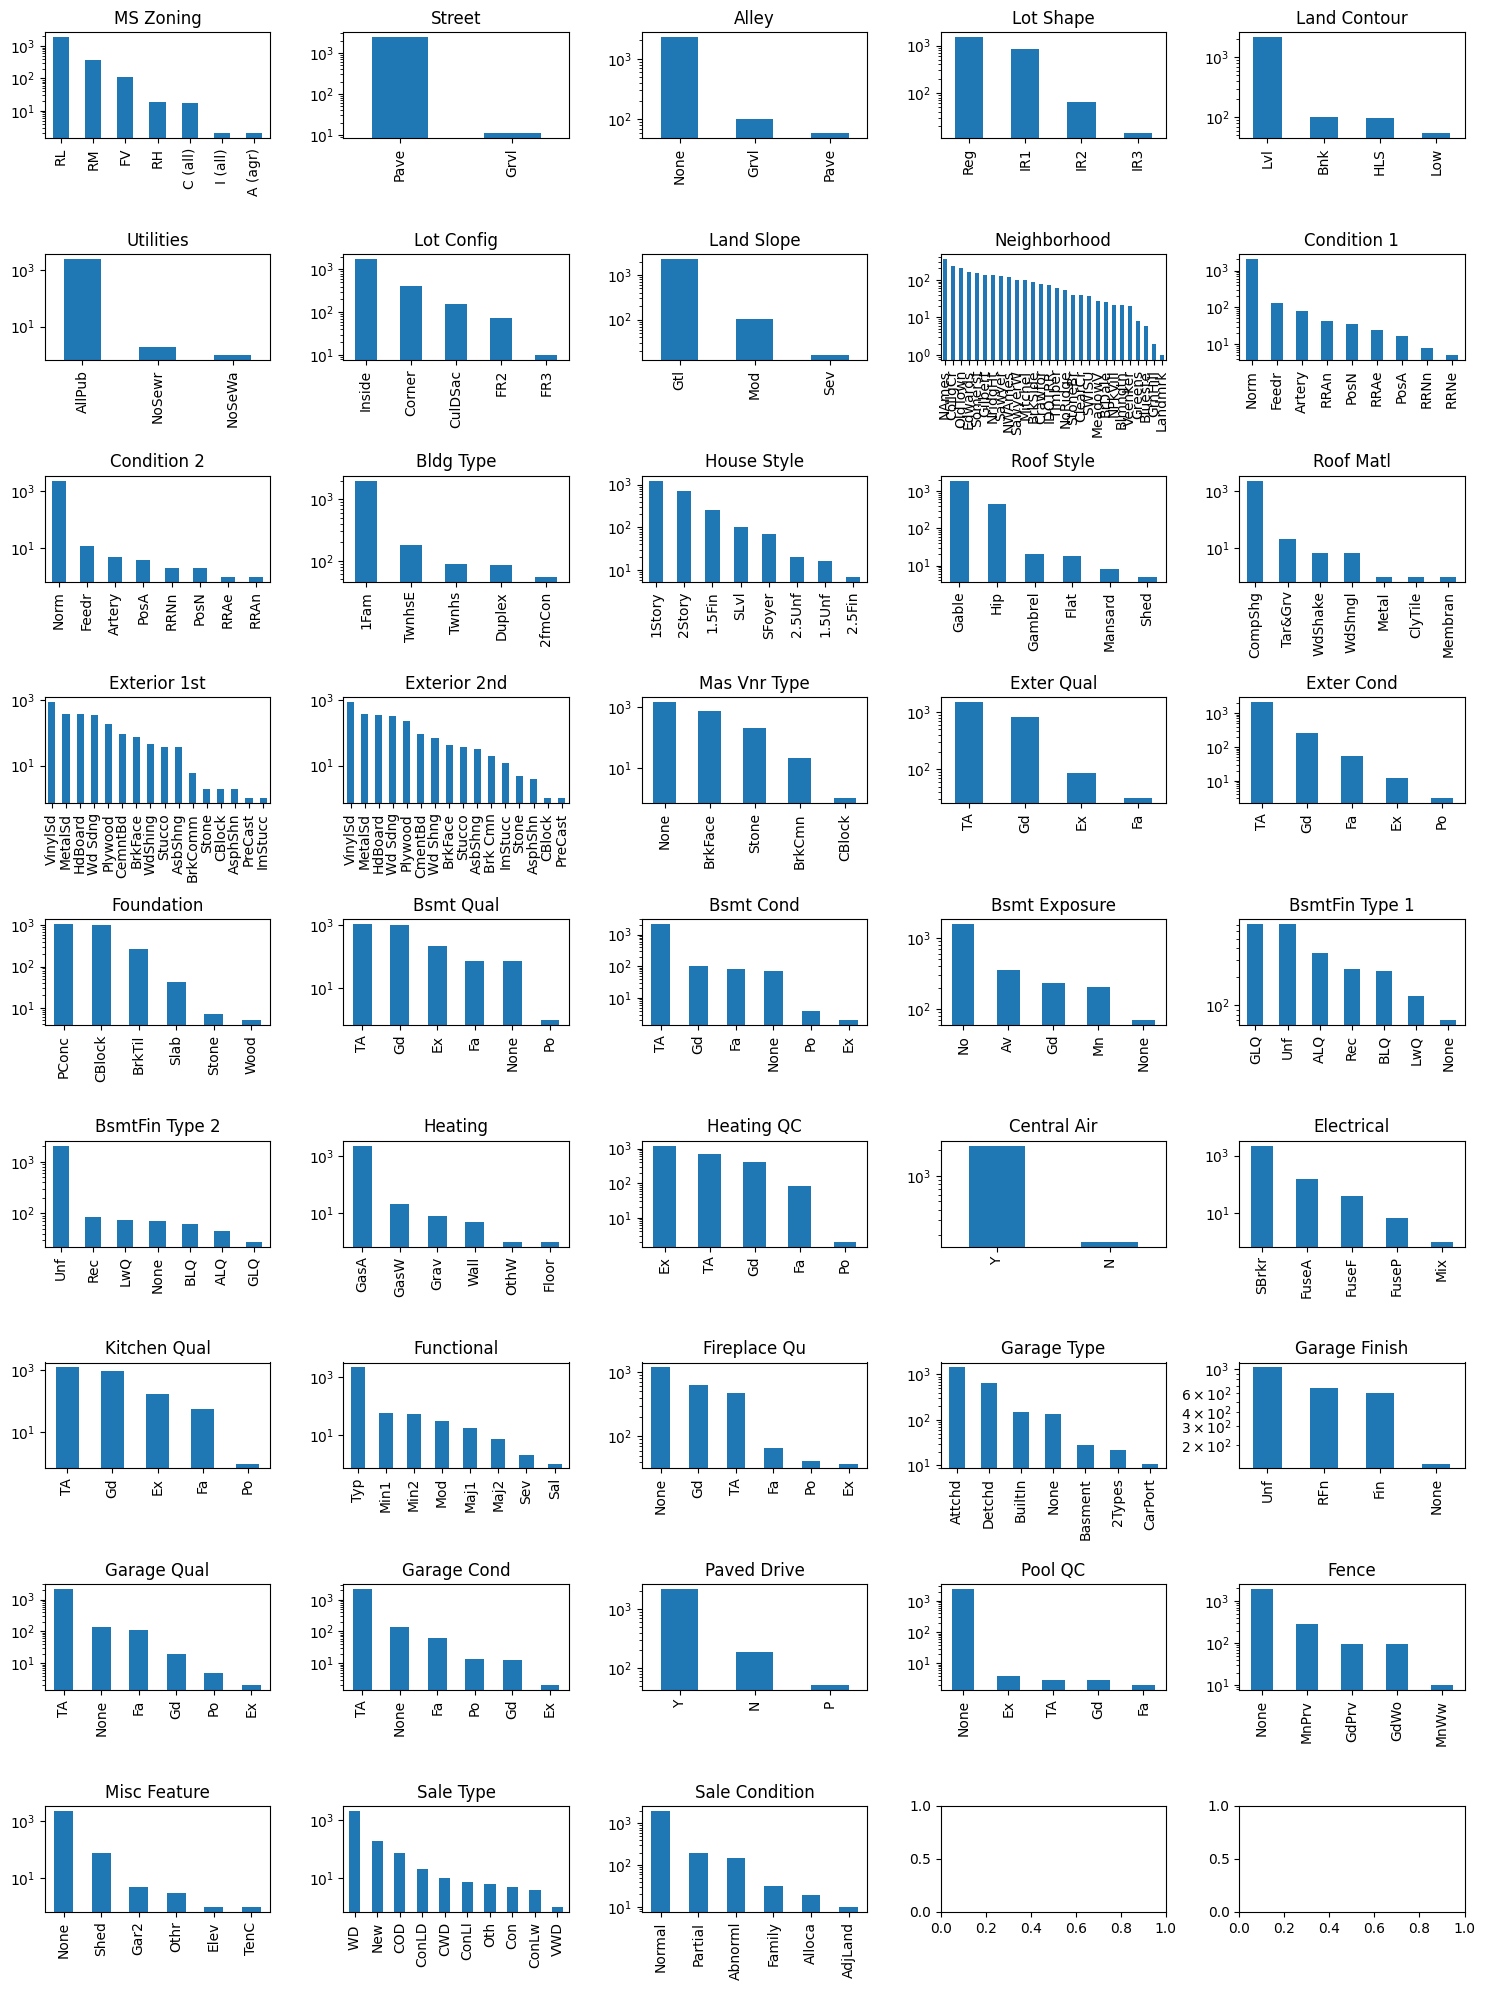

In [291]:
n_cols = 5
n_rows = 9

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 20))

for i, col in enumerate(categorical_columns):
    r, c = np.divmod(i, n_cols)
    df[col].value_counts().plot(kind='bar', ax=axs[r, c], logy=True)
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

__Observation__
- For most features there's a a difference in 1 or more orders of magnitude between most and least frequent values
- For the cate of categorical variables it doesn't make sense to talk about outlier points, since all values are in principle accepted as valid

## Numerical Discrete Features

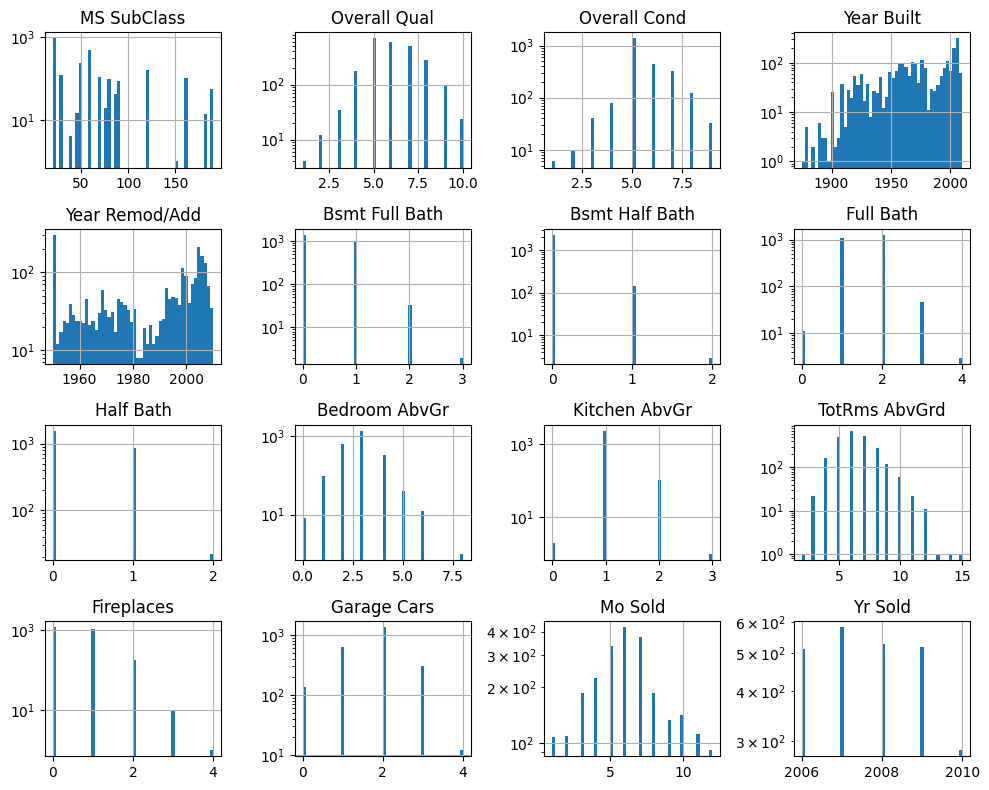

In [292]:
n_cols = 4
n_rows = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 8))

for i, col in enumerate(discrete_columns):
    r, c = np.divmod(i, n_cols)
    df[col].hist(bins=50, ax=axs[r, c], log=True)
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

## Numerical Continuous Features

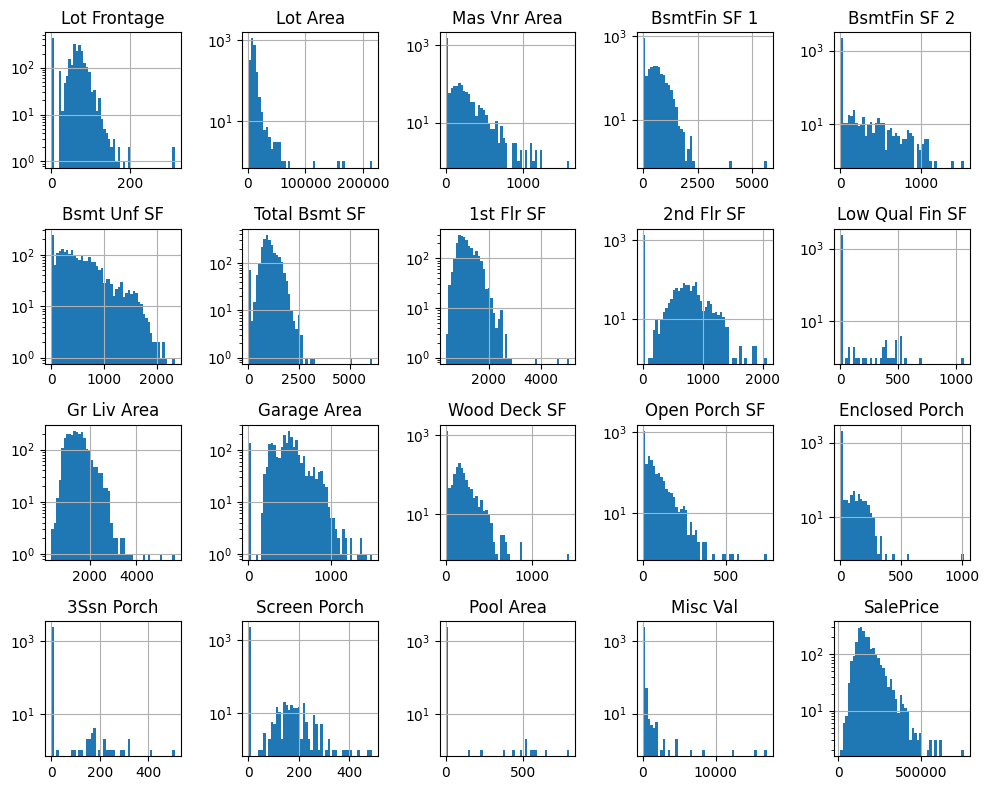

In [293]:
n_cols = 5
n_rows = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,8))

for i, col in enumerate(continuous_columns):
    r, c = np.divmod(i, n_cols)
    df[col].hist(bins=50, ax=axs[r, c], log=True)
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

# Relationship with target variable

## Categorical Features

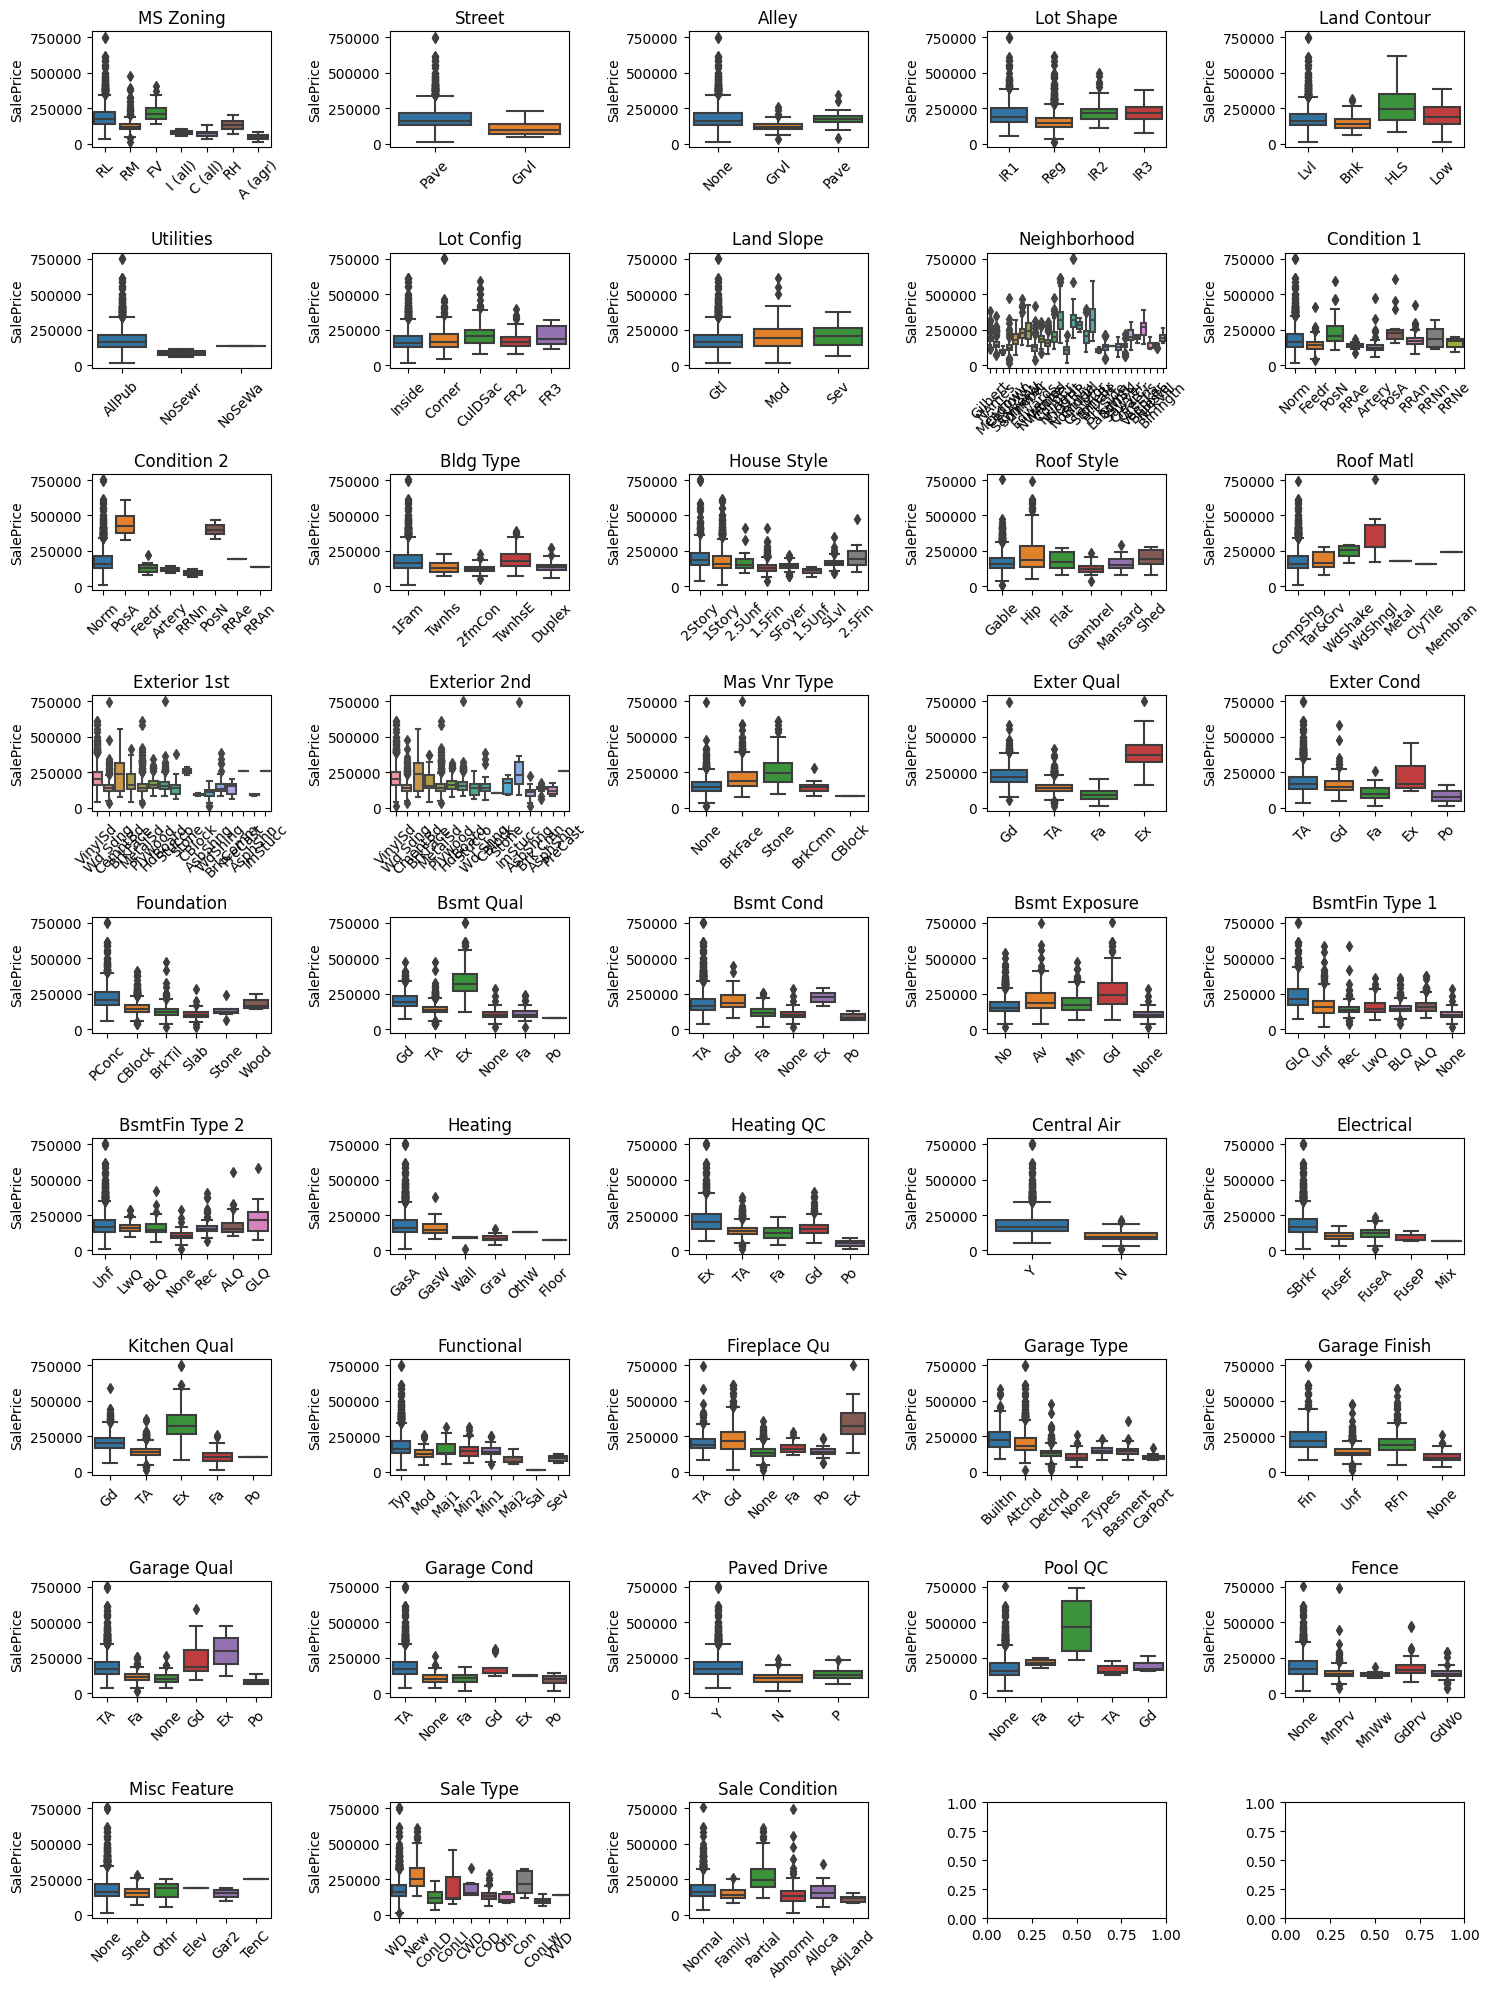

In [294]:
n_cols = 5
n_rows = 9

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 20))

for i, col in enumerate(categorical_columns):
    r, c = np.divmod(i, n_cols)
    sns.boxplot(x=col, y='SalePrice', data=df, ax=axs[r, c])
    #axs[r, c].set_yscale('log')
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
    for label in axs[r, c].get_xticklabels():
        label.set_rotation(45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

__Observations__:
- There's a big diversity on how the categorical features relate to the 'Sale Price'
- For a few features there's a big effect, depending on the labels and specially for predicting high values of 'Sale Price', e.g. for 'neighbourhood', 'Condition 2', 'Pool Qc'
- For many of the ordinal features there seems to be trend that could be well adjusted by a linear relationship if the labels were ordered differently
- Other features show almost no correlation, e.g. 'Slope', 'Lot Config', 'Lot Shape'
- Additionally, others seem to show no effect with respect with most of the labels in the feature except for 1 or 2, e.g. 'Pool QC'  

In [295]:
df_categorical_missing = df[categorical_columns].isna().sum().to_frame(name='total')
df_categorical_missing = df_categorical_missing[df_categorical_missing['total']!=0].sort_values('total', ascending=False)
df_categorical_missing['percentage'] = df_categorical_missing['total']/len(df)*100
df_categorical_missing.head()

,total,percentage
MS Zoning,1,0.04
Fireplace Qu,1,0.04
BsmtFin Type 1,1,0.04
BsmtFin Type 2,1,0.04
Heating,1,0.04


## Numerical Discrete Features

Relationship with target variable:

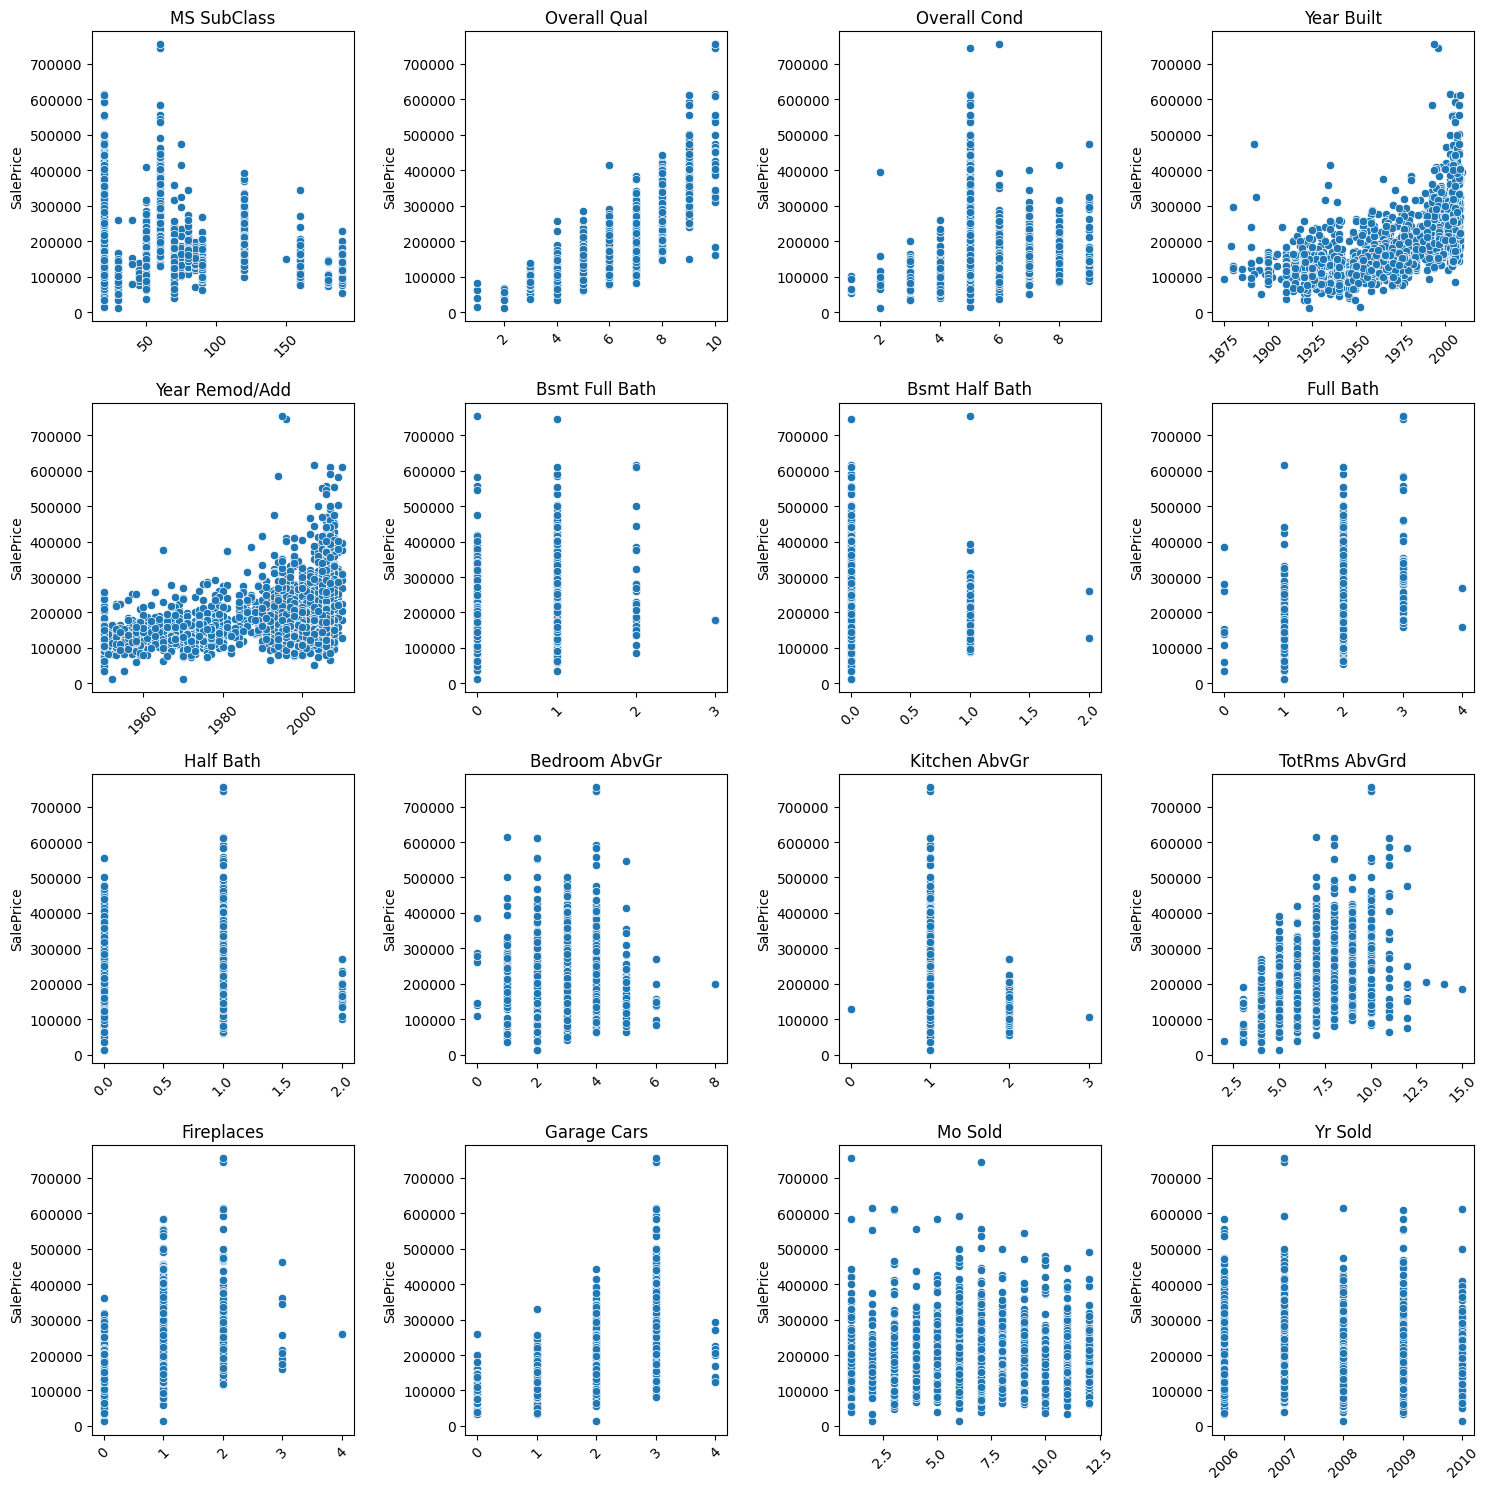

In [296]:
n_cols = 4
n_rows = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,15))

for i, col in enumerate(discrete_columns):
    r, c = np.divmod(i, n_cols)
    sns.scatterplot(x=col, y='SalePrice', data=df, ax=axs[r, c])
    #axs[r, c].set_yscale('log')
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
    for label in axs[r, c].get_xticklabels():
        label.set_rotation(45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

Correlation with target variable:

In [297]:
correlations = df[discrete_columns.tolist()+['SalePrice']].corr()['SalePrice'].abs().sort_values(ascending=False)
print("Correlation of numerical discrete features with SalePrice:")
print(correlations)

Correlation of numerical discrete features with SalePrice:
SalePrice        1.00
Overall Qual     0.80
Garage Cars      0.64
Year Built       0.56
Full Bath        0.54
Year Remod/Add   0.53
Fireplaces       0.49
TotRms AbvGrd    0.48
Half Bath        0.28
Bsmt Full Bath   0.28
Bedroom AbvGr    0.13
Kitchen AbvGr    0.12
Overall Cond     0.10
MS SubClass      0.09
Mo Sold          0.04
Bsmt Half Bath   0.03
Yr Sold          0.03
Name: SalePrice, dtype: float64


Correlation among numerical discrete variables:

Correlation of numerical discrete among themselves:


<Axes: >

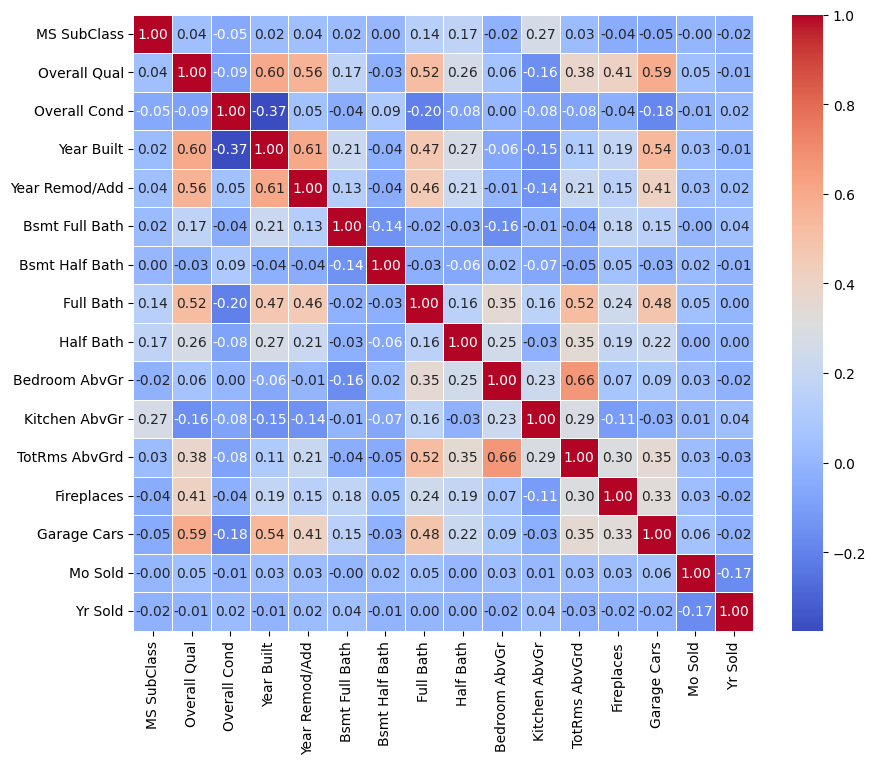

In [298]:
correlation_matrix = df[discrete_columns].corr()

print("Correlation of numerical discrete among themselves:")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

## Numerical Contiuous Features

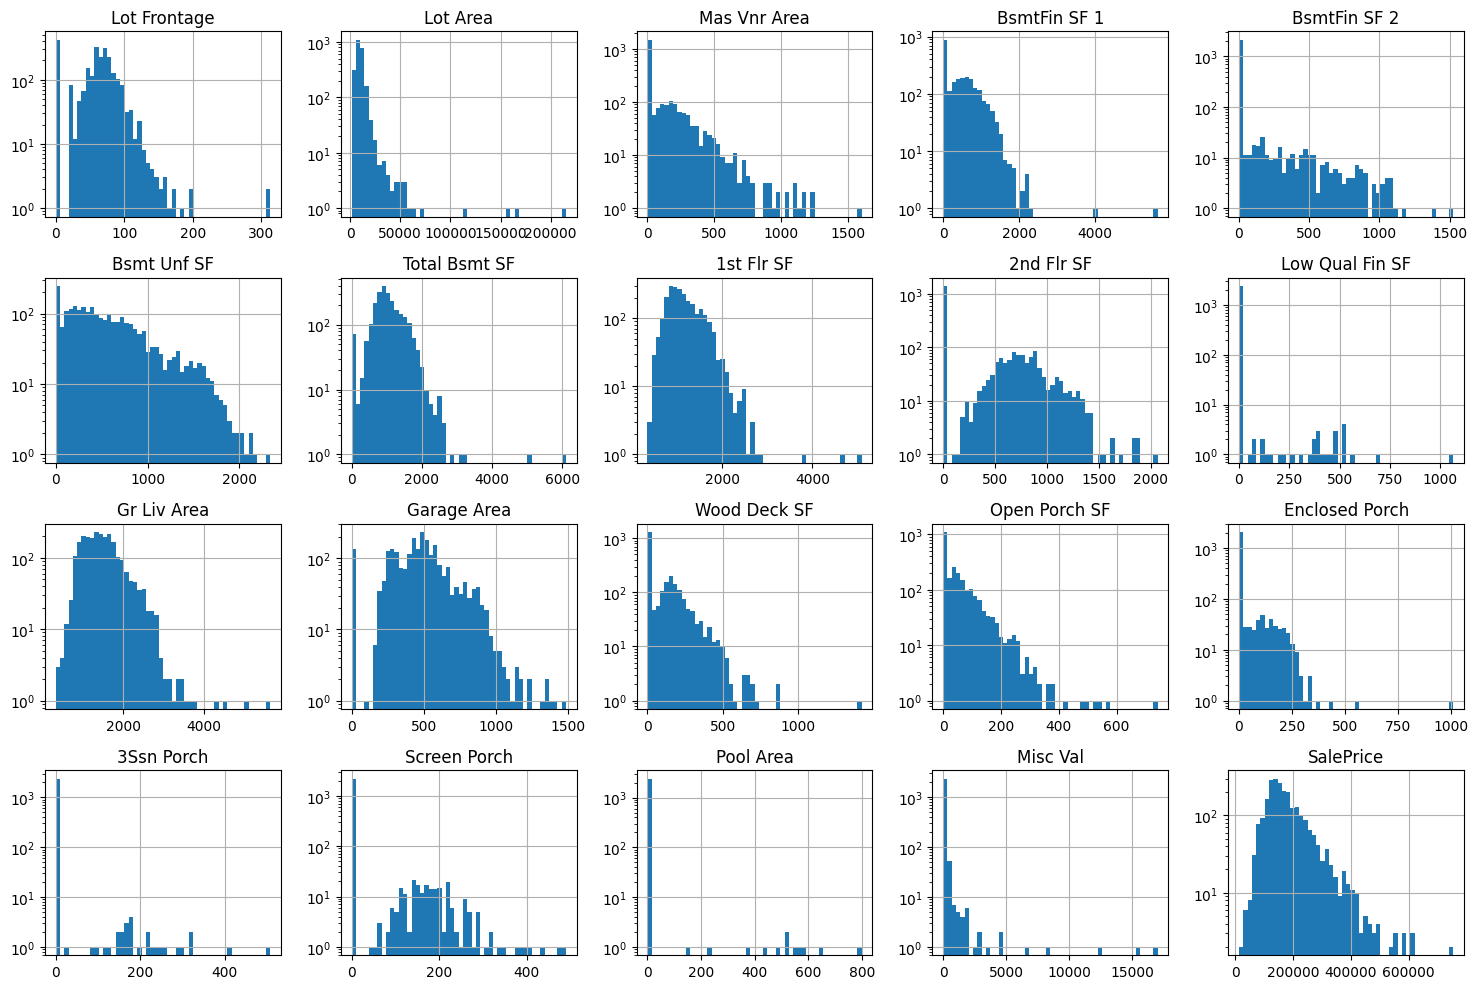

In [299]:

n_cols = 5
n_rows = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, col in enumerate(continuous_columns):
    r, c = np.divmod(i, n_cols)
    df[col].hist(bins=50, ax=axs[r, c], log=True)
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
    
plt.tight_layout()
plt.show()

In [300]:
continuous_columns.size

20

In [301]:
correlations = df[continuous_columns].corr()['SalePrice'].abs().sort_values(ascending=False)
print("Correlation of numerical continuous features with SalePrice:")
print(correlations)

Correlation of numerical continuous features with SalePrice:
SalePrice         1.00
Gr Liv Area       0.70
Total Bsmt SF     0.64
Garage Area       0.63
1st Flr SF        0.63
Mas Vnr Area      0.51
BsmtFin SF 1      0.44
Wood Deck SF      0.32
Open Porch SF     0.30
Lot Area          0.25
2nd Flr SF        0.25
Lot Frontage      0.20
Bsmt Unf SF       0.18
Enclosed Porch    0.14
Screen Porch      0.12
Pool Area         0.07
3Ssn Porch        0.04
Low Qual Fin SF   0.03
Misc Val          0.02
BsmtFin SF 2      0.01
Name: SalePrice, dtype: float64


Correlation among numerical continuous variables:

Correlation of numerical continuous among themselves:


<Axes: >

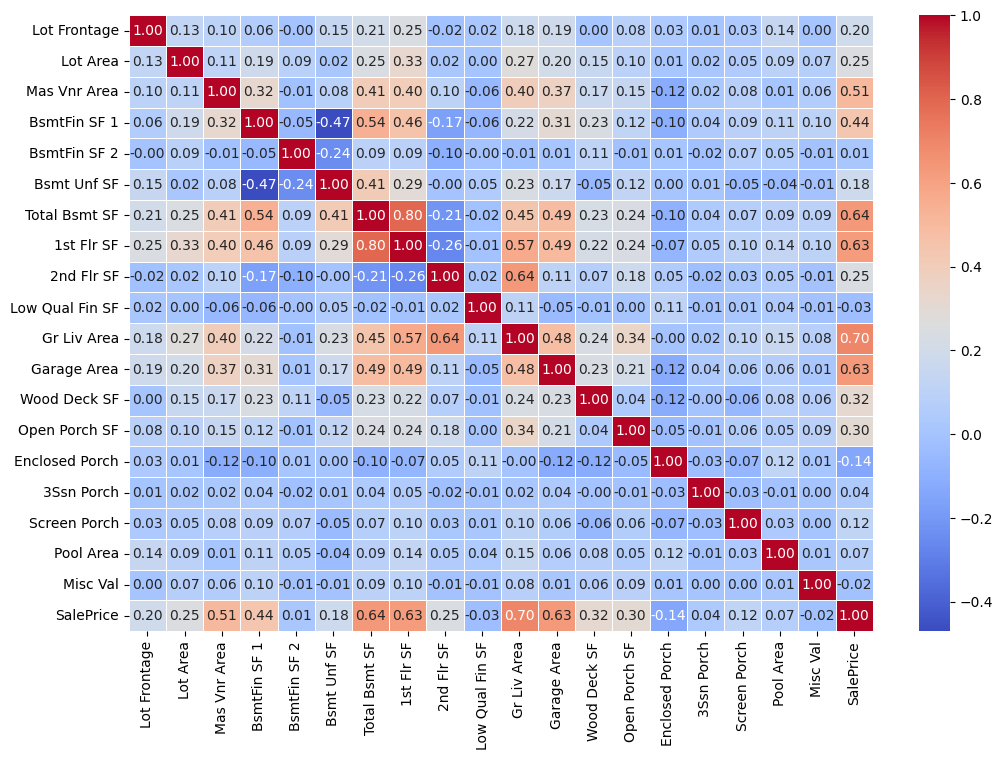

In [302]:
correlation_matrix = df[continuous_columns].corr()

print("Correlation of numerical continuous among themselves:")
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

# Enconding of Categorical Variables

__Observation__:
- Features such as 'Exter Cond', 'Exter Cond', 'Garage Finish', have an ordinal nature despite being part of the categorical variables
- We can use this fact to directly encode them into numerical discrete variables

  
__Solution__:
- Encode the following categorical ordinal features: 'Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive'
- Assume a linear relationship between 'SalePrice' and all the categorical ordinal features (following observation of previous plots and information in documentation)
- Label encode these categorical variables into numerical discrete ones,  avoiding the creation of many new extra variables with "one-hot encoding"

In [303]:
encoding_order={
    'Lot Shape':['Reg', 'IR1', 'IR2', 'IR3'], 
    'Utilities':['AllPub', 'NoSewr', 'NoSeWa', 'ELO'],
    'Land Slope':['Gtl', 'Mod', 'Sev'],
    'Overall Qual': ['10', '9', '8', '7', '6', '5', '4', '3', '2', '1'],
    'Overall Cond': ['10', '9', '8', '7', '6', '5', '4', '3', '2', '1'],
    'Exter Qual':['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Exter Cond':['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Bsmt Qual':['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'Bsmt Cond':['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'Bsmt Exposure':['Gd', 'Av', 'Mn', 'No', 'NA'], 
    'BsmtFin Type 1':['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    'BsmtFin Type 2':['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    'Heating QC':['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Electrical':['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'],
    'Kitchen Qual':['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Functional':['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],
    'Fireplace Qu':['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'Garage Finish':['Fin', 'RFn', 'Unf'],
    'Garage Qual':['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'Garage Cond':['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'Paved Drive':['Y', 'P', 'N'],
    'Pool QC': ['Ex', 'Gd', 'TA', 'Fa', 'NA'],
    'Fence': ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'],
    }

In [304]:
print("Missing values: ")
for col in encoding_order.keys():
    print(f'{col:20}: {df[col].isna().sum().sum()}')

Missing values: 
Lot Shape           : 1
Utilities           : 1
Land Slope          : 1
Overall Qual        : 1
Overall Cond        : 1
Exter Qual          : 1
Exter Cond          : 1
Bsmt Qual           : 1
Bsmt Cond           : 1
Bsmt Exposure       : 1
BsmtFin Type 1      : 1
BsmtFin Type 2      : 1
Heating QC          : 1
Electrical          : 1
Kitchen Qual        : 1
Functional          : 1
Fireplace Qu        : 1
Garage Finish       : 1
Garage Qual         : 1
Garage Cond         : 1
Paved Drive         : 1
Pool QC             : 1
Fence               : 1


In [305]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(categories=[['bad', 'average', 'good']])
df['col'] = ordinal_encoder.fit_transform(df[['col']])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 from sklearn.preprocessing import OrdinalEncoder                                             │
│   2                                                                                              │
│   3 ordinal_encoder = OrdinalEncoder(categories=[['bad', 'average', 'good']])                    │
│ ❱ 4 df['col'] = ordinal_encoder.fit_transform(df[['col']])                                       │
│   5                                                                                              │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/frame.py:3899 in __getitem__                                                                 │
│                                                                                                  │
│    3896 │   │   else:                                                                            │
│    3897 │   │   │   if is_iterator(key):                                                         │
│    3898 │   │   │   │   key = list(key)                                                          │
│ ❱  3899 │   │   │   indexer = self.columns._get_indexer_strict(key, "columns")[1]                │
│    3900 │   │                                                                                    │
│    3901 │   │   # take() does not accept boolean indexers                                        │
│    3902 │   │   if getattr(indexer, "dtype", None) == bool:                                      │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/indexes/base.py:6114 in _get_indexer_strict                                                  │
│                                                                                                  │
│   6111 │   │   else:                                                                             │
│   6112 │   │   │   keyarr, indexer, new_indexer = self._reindex_non_unique(keyarr)               │
│   6113 │   │                                                                                     │
│ ❱ 6114 │   │   self._raise_if_missing(keyarr, indexer, axis_name)                                │
│   6115 │   │                                                                                     │
│   6116 │   │   keyarr = self.take(indexer)                                                       │
│   6117 │   │   if isinstance(key, Index):                                                        │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/indexes/base.py:6175 in _raise_if_missing                                                    │
│                                                                                                  │
│   6172 │   │   │   if nmissing == len(indexer):                                                  │
│   6173 │   │   │   │   if use_interval_msg:                                                      │
│   6174 │   │   │   │   │   key = list(key)                                                       │
│ ❱ 6175 │   │   │   │   raise KeyError(f"None of [{key}] are in the [{axis_name}]")               │
│   6176 │   │   │                                                                                 │
│   6177 │   │   │   not_found = list(ensure_index(key)[missi

In [57]:
correlations = df[continuous_columns.tolist()].corr()['SalePrice'].abs().sort_values(ascending=False)
print(correlations)

SalePrice          1.000000
Gr Liv Area        0.700401
Total Bsmt SF      0.635582
Garage Area        0.630639
1st Flr SF         0.625878
Mas Vnr Area       0.505822
BsmtFin SF 1       0.439641
Wood Deck SF       0.315394
Open Porch SF      0.300855
Lot Area           0.252236
2nd Flr SF         0.245253
Lot Frontage       0.195207
Bsmt Unf SF        0.180182
Enclosed Porch     0.138272
Screen Porch       0.119816
Pool Area          0.072110
3Ssn Porch         0.038948
Low Qual Fin SF    0.030083
Misc Val           0.016725
BsmtFin SF 2       0.012971
Name: SalePrice, dtype: float64


# EDA and Data Cleaning

### Missing values
We start by observing the occurrence of missing values and next we see how to address these

In [ ]:
df.isnull().sum().sum()

In [ ]:
df_missing = df.isna().sum().to_frame(name='total')
df_missing = df_missing[df_missing['total']!=0].sort_values('total', ascending=False)
df_missing['percentage'] = df_missing['total']/len(df)*100
df_missing

In [ ]:
df.isnull().sum().sum()

In [ ]:
df_missing = df.isna().sum().to_frame(name='total')
df_missing = df_missing[df_missing['total']!=0].sort_values('total', ascending=False)
df_missing['percentage'] = df_missing['total']/len(df)*100
df_missing

Except for 'Electrical', all reamining columns with missing values are numerical. So let's handle 'Electrical' first. We chose the most common value to fill in the only missing entry.

In [ ]:
df['Electrical'].fillna(value=df['Electrical'].mode, inplace=True)

Reading the description of 'Lot Frontage' one sees that this is a continuous variable indicating 'Linear feet of street connected to property', it seems reasonable to assume if a house has no lot frontage then this could be set to 0.

In [ ]:
df['Lot Frontage'].hist(bins=50)
df['Lot Frontage'].fillna(0, inplace=True)

We apply the same principle to all other missing values, which at this point are present only in numerical columns.

In [ ]:
## CHECK!!
df.fillna(0, inplace=True)

In [ ]:
df.isnull().sum().sum()

### Inconsistencies

In [ ]:
sum(df['Year Remod/Add'] < df['Year Built'])

In [ ]:
(df['Bsmt Qual']=='None')!=(df['Bsmt Cond']=='None')

In [ ]:
sum((df['Bsmt Qual']=='None')+(df['Bsmt Cond']=='None'))

In [ ]:
print(sum(df['Bsmt Qual']=='None'))
print(sum(df['Bsmt Cond']=='None'))
print(sum(df['Bsmt Exposure']=='None'))
print(sum((df['Bsmt Qual']=='None') & (df['Bsmt Cond']=='None')))


In [ ]:
((df['Bsmt Qual']=='None')!=(df['Bsmt Cond']=='None')+(df['Bsmt Exposure']=='None'))

### Outliers

__Exploring the categorical variables__

In [ ]:
df_cat = df.loc[:,df.dtypes == 'object'].copy()
df_cat.nunique()

__Exploring the numerical variables__

In [ ]:
df.describe().loc[['min', 'max']].T

__Observation:__
- 'Garage Yr Blt': Minimum value is 0 and maximum is 2207 which clearly is an error since dataset only goes up to 2010

__Solution:__
- Remove entries where 'Garage Yr Blt' > 2010
- Remove entries where 'Garage Yr Blt' > 0

In [ ]:
mask = (df['Garage Yr Blt'] > 0) & (df['Garage Yr Blt'] < 2010)
df = df[mask]
df.shape

In [ ]:
df.hist(bins=20, figsize=(20,20), log=True)
plt.show()

In [ ]:
pd.set_option('display.float_format', '{:.5f}'.format)
corr_series = df[cols_per_hundred].corrwith(df['energy_per_hundred'])
corr_series.sort_values(ascending=False)